# 1.匯入套件

In [1]:
#常用
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
import warnings
warnings.filterwarnings('ignore')

#統計
import scipy.stats as st

#機器學習
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

In [195]:
###資料匯入
class DataImport:
    def __init__(self):
        self.data_dir = os.getcwd()
    
    #資料夾路徑
    def set_dir(self, data_path):
        self.data_dir = os.path.join(self.data_dir, data_path)
    
    #壓縮檔名 
    def read_zip(self, filename):
        self.file_path = os.path.join(self.data_dir, filename)
        print('Path of read in data: %s' % (self.file_path))
        myzip=ZipFile(self.file_path)
        for i in myzip.filelist:
            print(i.filename)
        myzip.close()
    
    #讀取壓縮檔內的資料
    def read_zip_data(self, dataname):
        myzip=ZipFile(self.file_path)
        f=myzip.open(dataname)
        df=pd.read_csv(f)
        f.close()
        myzip.close()
        return df


### EDA
#ref : https://www.kaggle.com/dgawlik/house-prices-eda
class EDA:
    
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    
    def get_features_type(self):
        self.numeric_features=[]
        self.categorical_features = []
        for dtype, feature in zip(self.train.dtypes, self.train.columns):
            if dtype == 'object':
                self.categorical_features.append(feature)
            else :
                self.numeric_features.append(feature)
    
    
    def categorical_check(self):    
        categorical_type = self.train[self.categorical_features].apply(pd.Series.nunique, axis = 0).reset_index() 
        categorical_type.columns = ["Column", "Unique Count"]
        display(categorical_type.head(len(self.categorical_features))) 
    
    def na_check(self):
        data_na = (self.train.isnull().sum() / len(self.train)) * 100
        data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio' :data_na})
        display(missing_data.head(data_na.shape[0]))
    
    def overview(self):
        print('Train data :{}'.format(self.train.shape))
        print('Test data :{}'.format(self.test.shape))
        print('\n')
        print(f'{len(self.numeric_features)} Numeric_Features : {self.numeric_features}\n')
        print(f'{len(self.categorical_features)} Categorical Features : {self.categorical_features}\n')
        print('\n')
        self.categorical_check()
        self.na_check()
        
    def drop_feature(self, name):
        try:
            self.numeric_features.remove(name)
            print('Remove finish')
        except:
            try:
                self.categorical_features.remove(name)
                print('Remove finish')
            except:
                pass
        
    def set_target(self, name):
        self.target = name
        try:
            self.numeric_features.remove(name)
            print('Set finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Set finish')
        except:
            pass
    
    def y_distribution(self, log1p=False):
        if log1p:
            train_y = np.log1p(self.train[self.target])
        else:
            train_y = self.train[self.target]
        plt.figure(1,figsize=(8, 6))
        plt.title('Y')
        sns.distplot(train_y, 
                     kde=False, 
                     fit=st.norm)

        plt.figure(2,figsize=(8, 6))
        res = st.probplot(train_y,plot=plt)
        plt.show()
        
    def numeric_plot(self):
        for c in self.numeric_features:
            num_plot = sns.jointplot(x=c, y=self.target, data=self.train,kind='scatter',color='#0066CC')
            num_plot.ax_joint.set_ylabel(self.target,rotation=0)
            plt.show()
    
    def categorical_plot(self):
        for c in self.categorical_features:
            sns.boxplot(x = c, y = self.target, data=self.train,color='#0066CC')
            plt.xticks(rotation=90)
            plt.show()
    
    def anova(self):
        frame = self.train.copy()
        anv = pd.DataFrame()
        anv['feature'] = self.numeric_features
        pvals = []
        for c in self.numeric_features:
            samples = []
            for cls in frame[c].unique():
                s = frame[frame[c] == cls][self.target].values
                samples.append(s)
            pval = st.f_oneway(*samples)[1]
            pvals.append(pval)
        anv['pval'] = pvals
        anv = anv.sort_values('pval')
        anv['disparity'] = np.log(1./anv['pval'].values)
        self.anv = anv
        plt.figure(1,figsize=(8, 6))
        sns.barplot(data=anv, x='feature', y='disparity')
        x=plt.xticks(rotation=90)
        plt.show()
        
    def spearman(self):
        frame = self.train.copy()
        spr = pd.DataFrame()
        spr['feature'] = self.numeric_features
        spr['spearman'] = [frame[c].corr(frame[self.target], 'spearman') for c in self.numeric_features]
        spr = spr.sort_values('spearman')
        self.spr = spr
        plt.figure(figsize=(6, 0.25*len(self.numeric_features)))
        sns.barplot(data=spr, y='feature', x='spearman', orient='h')
        plt.show()
        
    def correlation_matrix(self):
        correlations = self.train.loc[:,self.numeric_features].corr()
        plt.figure(1,figsize=(8, 6))
        sns.heatmap(correlations,
                    cmap = 'seismic',
        #             annot=True,
                    fmt ='0.1g',
                    center = 0)
        plt.show()

        
class Outlier:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    def set_target(self, name, func=False):
        self.target_name = name
        if func:
            self.target = pd.Series(map(func,self.train[name]))
        else:
            self.target = self.train[name]
    
    def target_distribution(self):
        plt.figure(1,figsize=(8, 6))
        plt.title(self.target_name)
        sns.distplot(self.target, 
                     kde=False, 
                     fit=st.norm)

        plt.figure(2,figsize=(8, 6))
        res = st.probplot(self.target,plot=plt)
        plt.show()
    
    def summarize(self):
        print('{} Missing Number: {} , Missing Ratio: {}'.format(self.target_name ,
                                                                 sum(self.target.isna()) ,
                                                                 sum(self.target.isna())/len(self.target))
             )
        print('{} Skewness is {:.2f}'.format(self.target_name, self.target.skew()))
        print('{} Kurtosis is {:.2f}'.format(self.target_name, self.target.kurt()))
        self.target_distribution()
    
    def boxplot_calculate(self):
        sns.boxplot(outlier.target)
        plt.show()
        self.q1 = np.quantile(self.target, 0.25)
        self.q2 = np.quantile(self.target, 0.5)
        self.q3 = np.quantile(self.target, 0.75)
        self.iqr = self.q3-self.q1
        self.upper_bound = self.q3+(1.5*self.iqr)
        self.lower_bound = self.q1-(1.5*self.iqr)
        self.box_outlier_index = self.target[(self.target<self.lower_bound)|(self.target>self.upper_bound)].index
        print('number of outlier(box) : {}'.format(len(self.box_outlier_index)))
        
    def standard_calculate(self):
        z_scaler = StandardScaler()
        self.target_z = z_scaler.fit_transform(self.target.values.reshape(-1, 1))
        self.target_z = pd.Series(self.target_z.reshape(-1, ))
        self.z_outlier_index = self.target_z[(self.target_z<-3)|(self.target_z>3)].index
        print('number of outlier(z) : {}'.format(len(self.z_outlier_index)))

class Feature_Engineering:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    def get_features_type(self):
        self.numeric_features=[]
        self.categorical_features = []
        for dtype, feature in zip(self.train.dtypes, self.train.columns):
            if dtype == 'object':
                self.categorical_features.append(feature)
            else :
                self.numeric_features.append(feature)
                
    def drop_feature(self, name):
        try:
            self.numeric_features.remove(name)
            print('Remove finish')
        except:
            try:
                self.categorical_features.remove(name)
                print('Remove finish')
            except:
                pass

    def set_target(self, name):
        self.target = name
        try:
            self.numeric_features.remove(name)
            print('Set finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Set finish')
        except:
            pass
    
    def drop_outlier(self, index):
        self.train = self.train.drop(index)
        print('Drop {} rows'.format(len(index)))
    
    def split_train_yX(self):
        self.train_y = self.train[self.target]
        self.train_X = self.train[self.numeric_features + self.categorical_features]
        
    def numeric_missing_value(self, cols, how='fillna_median', group_by=False):
        if how =='fillna_median':
            for c in cols:
                self.train_X[c] = self.train_X[c].fillna(self.train_X[c].median())
        elif how =='fillna_0':
            for c in cols:
                self.train_X[c] = self.train_X[c].fillna(0)
    
    def numeric_discretize(self, cols, n):
        for c in cols:
            self.train_X[c] = pd.cut(self.train_X[c],n,labels=range(n))
    
    def numeric_adding(self, cols):
        for c in cols:
            self.train_X[c+'_squared'] = self.train_X[c]**2
            self.numeric_features = self.numeric_features.append(c+'_squared')
    
    def numeric_log_transform(self, cols):
        for c in cols:
            self.train_X[c] = np.log1p(self.train_X[c])
    
    def numeric_z_score(self):
        self.z_score = StandardScaler()
        self.z_score.fit(self.train_X[self.numeric_features])
        self.train_X[self.numeric_features] = self.z_score.transform(self.train_X[self.numeric_features])
    
    def numeric_MMscaler(self):
        self.MMscaler = MinMaxScaler()
        self.MMscaler.fit(self.train_X[self.numeric_features])
        self.train_X[self.numeric_features] = self.MMscaler.transform(self.train_X[self.numeric_features])
        
    def categorical_missing_value(self, cols, how='fillna_NA', group_by=False):
        if how =='fillna_NA':
            for c in cols:
                self.train_X[c] = self.train_X[c].fillna('NA')
    
    def categorical_encoding(self, how = 'one_hot', drop_first=False):
        if how == 'one_hot':
            df_onehot = pd.get_dummies(self.train_X[self.categorical_features],drop_first=drop_first)
            self.categorical_features = list(df_onehot.columns)
            self.train_X = pd.concat([self.train_X[self.numeric_features],df_onehot],axis=1)
    
    def filter_corr(self, features, corr=0.2):
        print('Before : {}'.format(len(features)))
        frame = self.train_X[features].copy()
        spr = pd.DataFrame()
        spr['feature'] = features
        spr['spearman'] = [frame[c].corr(self.train_y, 'spearman') for c in features]
        spr = spr.sort_values('spearman')
        for c in spr[abs(spr.spearman)<corr].feature:
            self.drop_feature(name=c)
        print('After : {}'.format(len(features)))
    
    def filter_anova(self, features, ratio=0.05):
        print('Before : {}'.format(len(features)))
        frame = self.train_X[features]
        anv = pd.DataFrame()
        anv['feature'] = features
        pvals = []
        for c in features:
            samples = []
            for cls in frame[c].unique():
                s = self.train_y[frame[c] == cls].values
                samples.append(s)
            pval = st.f_oneway(*samples)[1]
            pvals.append(pval)
        anv['pval'] = pvals
        anv = anv.sort_values('pval').reset_index(drop=True)
        anv['disparity'] = np.log(1./anv['pval'].values)
        for c in anv[anv.pval>0.05].feature:
            self.drop_feature(name=c)
        print('After : {}'.format(len(features)))
        
    def dimension_reduce_pca(self, features, n = 20):
        self.pca=PCA(n_components=n)
        self.pca.fit(self.train_X[features])
        self.train_X_pca = self.pca.transform(self.train_X[features])
        print(np.round(self.pca.explained_variance_ratio_, 4)[:2])
        print('Explained Variance Ratio : {}'.format(round(sum(self.pca.explained_variance_ratio_),2)))

# 2. 匯入資料

In [3]:
DTImport = DataImport()
DTImport.set_dir(data_path = './data/')
DTImport.read_zip(filename = 'house-prices.zip')
train = DTImport.read_zip_data(dataname = 'train.csv')
test = DTImport.read_zip_data(dataname = 'test.csv')

Path of read in data: C:\Users\RT009223\Github\Projects\SideProject\03_Kaggle_House_Prices\./data/house-prices.zip
data_description.txt
sample_submission.csv
test.csv
train.csv


# 3. EDA

In [4]:
eda = EDA(train=train, test=test)

Train data :(1460, 81)
Test data :(1459, 80)


38 Numeric_Features : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

43 Categorical Features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir

,Column,Unique Count
0,MSZoning,5
1,Street,2
2,Alley,2
3,LotShape,4
4,LandContour,4
5,Utilities,2
6,LotConfig,5
7,LandSlope,3
8,Neighborhood,25
9,Condition1,9


,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Remove finish
Set finish


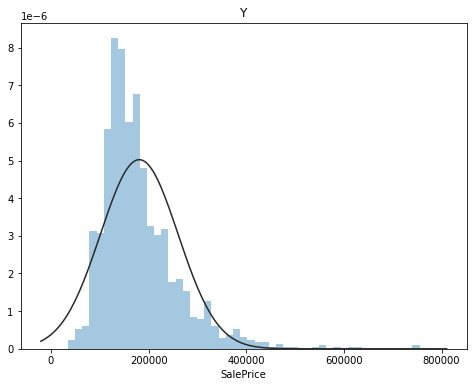

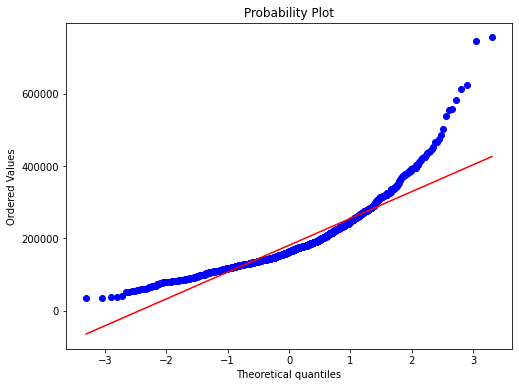

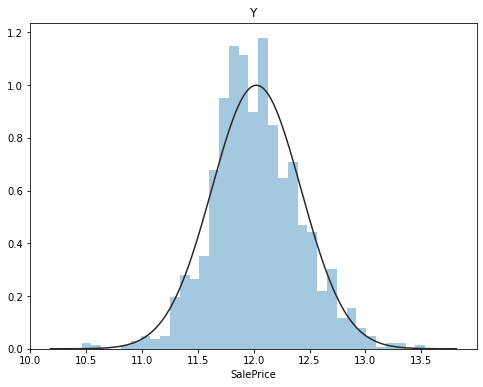

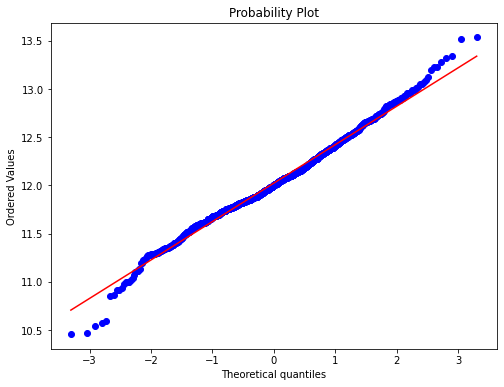

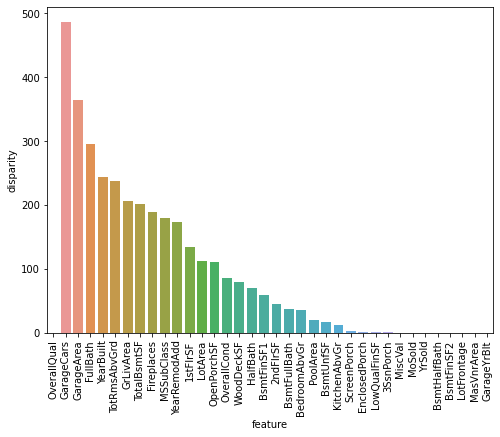

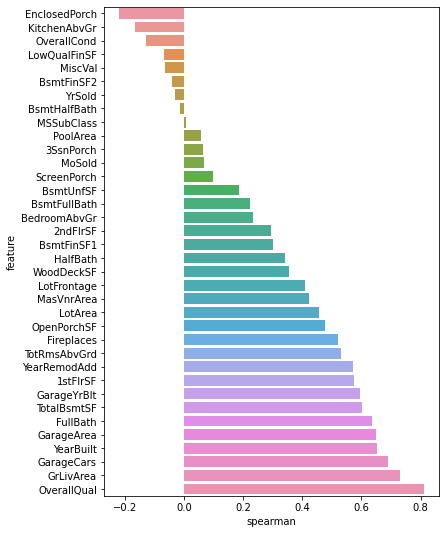

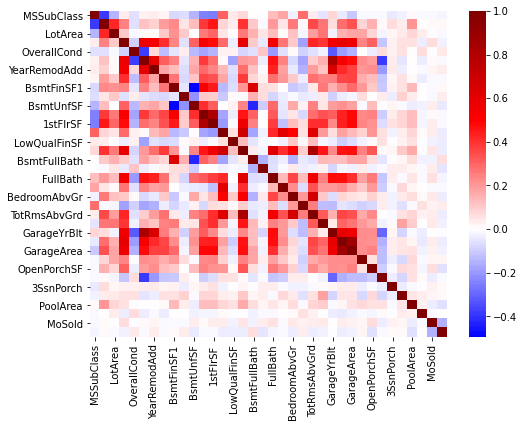

In [5]:
eda.get_features_type()
eda.overview()
eda.drop_feature(name='Id')
eda.set_target('SalePrice')
eda.y_distribution()
eda.y_distribution(log1p=True)

# eda.numeric_plot()
# eda.categorical_plot()

eda.anova()
eda.spearman()
eda.correlation_matrix()



In [6]:
outlier = Outlier(train= train, test= test)

SalePrice Missing Number: 0 , Missing Ratio: 0.0
SalePrice Skewness is 0.12
SalePrice Kurtosis is 0.81


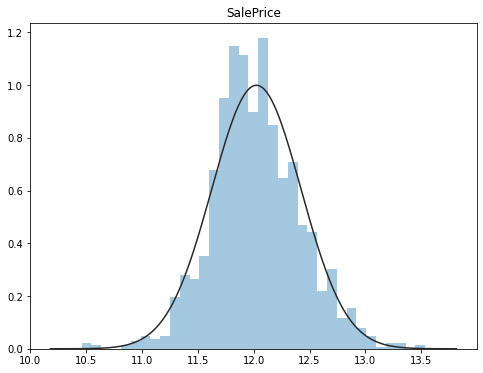

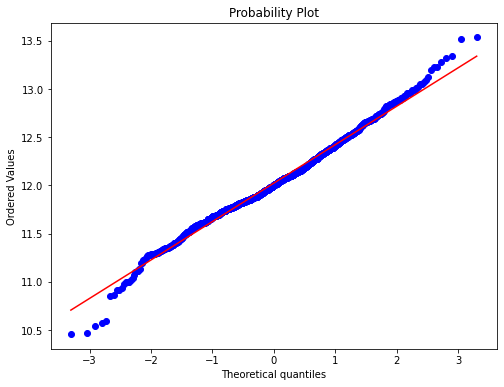

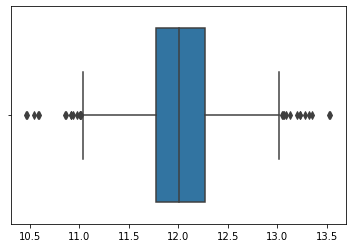

number of outlier(box) : 28
number of outlier(z) : 12


In [7]:
outlier.set_target(name='SalePrice' 
                   ,func=np.log1p
                  )
outlier.summarize()

outlier.boxplot_calculate()
outlier.standard_calculate()

In [8]:
print(eda.numeric_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


GarageYrBlt Missing Number: 81 , Missing Ratio: 0.05547945205479452
GarageYrBlt Skewness is -0.65
GarageYrBlt Kurtosis is -0.42


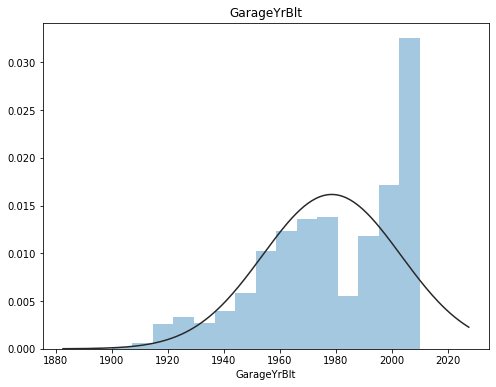

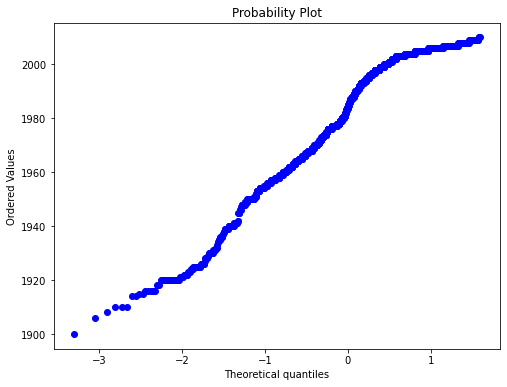

In [9]:
outlier.set_target(name='GarageYrBlt' 
#                    ,func=np.log1p
                  )
outlier.summarize()

In [26]:
df_test = eda.train.copy()
df_test[eda.categorical_features] = df_test[eda.categorical_features].fillna('NA')

In [28]:
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(-999)

In [29]:
df_test['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'NA', 'Basment',
       '2Types'], dtype=object)

In [59]:
df_test.loc[df_test.GarageYrBlt!=-999,:].groupby(['MasVnrType'])['MasVnrArea'].mean().reset_index()

,MasVnrType,MasVnrArea
0,BrkCmn,247.666667
1,BrkFace,259.008989
2,None,1.094907
3,Stone,239.304688


In [30]:
df_test.loc[df_test.GarageYrBlt==-999,:].groupby(['GarageType'])['GarageYrBlt'].count()

GarageType
NA    81
Name: GarageYrBlt, dtype: int64

In [27]:
df_test.loc[:,['GarageType','GarageYrBlt','GarageCars','GarageArea']]

,GarageType,GarageYrBlt,GarageCars,GarageArea
0,Attchd,2003.0,2,548
1,Attchd,1976.0,2,460
2,Attchd,2001.0,2,608
3,Detchd,1998.0,3,642
4,Attchd,2000.0,3,836
...,...,...,...,...
1455,Attchd,1999.0,2,460
1456,Attchd,1978.0,2,500
1457,Attchd,1941.0,1,252
1458,Attchd,1950.0,1,240


In [196]:
feature_egn = Feature_Engineering(train= train, test= test)

In [197]:
feature_egn.get_features_type()
feature_egn.drop_feature(name='Id')
feature_egn.drop_feature(name='TotalBsmtSF')
feature_egn.drop_feature(name='GrLivArea')
feature_egn.drop_feature(name='GarageYrBlt')
feature_egn.set_target('SalePrice')

feature_egn.drop_outlier(index= outlier.z_outlier_index)

Remove finish
Remove finish
Remove finish
Remove finish
Set finish
Drop 12 rows


In [198]:
feature_egn.split_train_yX()

In [199]:
cols_M = ['LotFrontage']
cols_0 = ['MasVnrArea']

feature_egn.numeric_missing_value(cols = cols_M, how='fillna_median', group_by=False)
feature_egn.numeric_missing_value(cols = cols_0, how='fillna_0', group_by=False)

In [200]:
feature_egn.train_y = np.log1p(feature_egn.train_y)

In [201]:
cols_log1p = ['MSSubClass','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
              'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
              'PoolArea','MiscVal']

feature_egn.numeric_log_transform(cols=cols_log1p)

In [202]:
feature_egn.numeric_z_score()
feature_egn.numeric_MMscaler()

In [203]:
feature_egn.categorical_missing_value(cols= feature_egn.categorical_features)

In [204]:
feature_egn.categorical_encoding(how='one_hot')

In [205]:
feature_egn.filter_corr(features=feature_egn.numeric_features,corr=0.2)
feature_egn.filter_anova(features=feature_egn.categorical_features,ratio=0.05)

Before : 33
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
After : 20
Before : 268
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finish
Remove finis

In [206]:
feature_egn.dimension_reduce_pca(features=feature_egn.numeric_features+feature_egn.categorical_features,
                                 n=40)

[0.159  0.0661]
Explained Variance Ratio : 0.8


In [174]:
pca=PCA(n_components=40)
pca.fit(feature_egn.train_X[feature_egn.numeric_features+feature_egn.categorical_features])
train_X = pca.transform(feature_egn.train_X[feature_egn.numeric_features+feature_egn.categorical_features])

In [160]:
train_X

array([[ 2.13824172,  0.4792766 ,  0.34890464, ..., -0.27695231,
         0.3609479 , -0.4255022 ],
       [-0.29558462, -0.98987274, -0.04561423, ..., -0.69672074,
        -0.52077592,  0.66109148],
       [ 2.55554736, -0.08062009,  1.01651074, ..., -0.07977165,
         0.57558619, -0.50708617],
       ...,
       [ 0.45689387,  0.32487111,  0.62845262, ..., -1.47221622,
        -0.15204533,  0.91241485],
       [-1.06516301, -0.77389868, -1.0059511 , ..., -0.52045768,
         0.24068659,  0.26556964],
       [-0.70834563, -0.90949999, -0.24267279, ..., -0.44921394,
        -0.44878428,  0.40675843]])

In [162]:
"""
解析英雄數據的前兩大主成份所代表的意涵。
顏色越突出代表其絕對值越大
"""
pcs = np.array(pca.components_) # (n_comp, n_features)

df_pc = pd.DataFrame(pcs, columns=feature_egn.numeric_features+feature_egn.categorical_features)
df_pc.index = [f"第{c}主成分" for c in['一', '二', '三', '四', '五', '六', '七', '八', '九', '十']]
df_pc.style\
    .background_gradient(cmap='bwr_r', axis=None)\
    .format("{:.2}")

In [178]:
np.round(pca.explained_variance_ratio_, 4)[:2]
sum(np.round(pca.explained_variance_ratio_, 2))

0.8100000000000005

In [176]:
sum(np.round(pca.explained_variance_ratio_, 2))

0.8100000000000005

In [180]:
np.round(pca.explained_variance_ratio_, 4)[:2]

array([0.159 , 0.0661])

In [158]:
feature_egn.train_X[feature_egn.numeric_features+feature_egn.categorical_features]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,1stFlrSF,2ndFlrSF,BsmtFullBath,...,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_ConLD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
0,0.413268,0.366271,0.666667,0.949275,0.883333,0.716038,0.759508,0.328506,0.899422,0.333333,...,0,0,0,0,0,1,0,0,1,0
1,0.490307,0.391245,0.555556,0.753623,0.433333,0.000000,0.797188,0.481654,0.000000,0.000000,...,0,0,0,0,0,1,0,0,1,0
2,0.429990,0.422289,0.666667,0.934783,0.866667,0.690361,0.716357,0.356948,0.901279,0.333333,...,0,0,0,0,0,1,0,0,1,0
3,0.383633,0.390223,0.666667,0.311594,0.333333,0.000000,0.622780,0.374148,0.883204,0.333333,...,0,0,0,0,0,1,1,0,0,0
4,0.508439,0.468694,0.777778,0.927536,0.833333,0.794318,0.750841,0.443264,0.927299,0.333333,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.395769,0.353519,0.555556,0.920290,0.833333,0.000000,0.000000,0.370850,0.871819,0.000000,...,0,0,0,0,0,1,0,0,1,0
1456,0.512839,0.453205,0.555556,0.768116,0.633333,0.648854,0.772504,0.677523,0.000000,0.333333,...,0,0,0,0,0,1,0,0,1,0
1457,0.418925,0.379525,0.666667,0.500000,0.933333,0.000000,0.650620,0.457810,0.939260,0.000000,...,0,1,0,0,0,1,0,0,1,0
1458,0.429990,0.393616,0.444444,0.565217,0.766667,0.000000,0.452858,0.419474,0.000000,0.333333,...,0,0,0,0,0,1,0,0,1,0


In [161]:
feature_egn.numeric_features+feature_egn.categorical_features

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_NA',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LotConfig_CulDSac',
 'LotConfig_Inside',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neigh

In [ ]:
#https://medium.com/%E7%84%A1%E9%82%8A%E6%8B%BC%E5%9C%96%E6%A1%86/kaggle-house-price-prediction-competition-%E5%AF%A6%E6%88%B0-ff1c846a9f14